In [1]:
import tensorflow as tf

2025-08-23 16:19:19.130111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755965959.320593      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755965959.380416      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
assert tf.config.list_physical_devices('GPU'), "No GPU detected: Check your Kaggle environment settings."

Num GPUs Available: 1


In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
# from keras_flops import get_flops


IMG_SIZE = (224, 224)  # Adjust as needed
BATCH_SIZE = 32
DROPOUT_RATE = 0.2
INITIAL_LR = 1e-5
EPOCHS = 100
SEED = 42

train_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/train'
val_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/val'
test_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/test'

datagen_args = dict(rescale=1./255)
train_gen = ImageDataGenerator(**datagen_args)
val_gen = ImageDataGenerator(**datagen_args)
test_gen = ImageDataGenerator(**datagen_args)
train_flow = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED)
val_flow = val_gen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_flow = test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
num_classes = train_flow.num_classes


Found 14219 images belonging to 43 classes.
Found 11955 images belonging to 43 classes.
Found 11958 images belonging to 43 classes.


In [4]:
base_model = ConvNeXtTiny(
    include_top=False, 
    weights='imagenet', 
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = True

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)

x = Dense(1024, activation='relu')(x)

x = Dense(512, activation='relu')(x)

x = Dense(256, activation='relu')(x)

x = Dense(128, activation='relu')(x)

output = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_flow.classes),
    y=train_flow.classes
)
class_weight_dict = dict(enumerate(class_weights))

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=INITIAL_LR, 
    weight_decay=0.01
)

print("Compiling model...")
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


I0000 00:00:1755965978.214175      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Compiling model...


In [5]:
print("\nModel Summary:")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")


Model Summary:
Total parameters: 29,302,155
Trainable parameters: 29,302,155


In [6]:
checkpoint_cb = ModelCheckpoint(
    "best_ConvNeXtTiny_model.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=7, 
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]

print("Starting training ")
!curl -d "convnexttiny Train Start" ntfy.sh/model_complete

# Train the whole model on your dataset
history = model.fit(
    train_flow,
    epochs=EPOCHS,
    validation_data=val_flow,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("Training completed!")
!curl -d "convnexttiny Train Complete" ntfy.sh/model_complete

with open('training_history.json', 'w') as f:
    json.dump(history.history,f)
    

Starting training 
{"id":"fK7xVlpSZbEU","time":1755965997,"expires":1756009197,"event":"message","topic":"model_complete","message":"convnexttiny Train Start"}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1755966040.683516     117 service.cc:148] XLA service 0x7956780064e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755966040.684152     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755966044.681982     117 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1755966048.177638     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755966048.353992     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755966048.599245     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755966048.7941

 31/445 ━━━━━━━━━━━━━━━━━━━━ 2:24 348ms/step - accuracy: 0.0320 - loss: 3.7623

E0000 00:00:1755966077.900151     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755966078.075869     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755966078.306858     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755966078.501442     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.0748 - loss: 3.5915
Epoch 1: val_accuracy improved from -inf to 0.16261, saving model to best_ConvNeXtTiny_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 313s 560ms/step - accuracy: 0.0749 - loss: 3.5909 - val_accuracy: 0.1626 - val_loss: 3.1626 - learning_rate: 1.0000e-05
Epoch 2/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.2951 - loss: 2.3830
Epoch 2: val_accuracy improved from 0.16261 to 0.34655, saving model to best_ConvNeXtTiny_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 196s 441ms/step - accuracy: 0.2952 - loss: 2.3824 - val_accuracy: 0.3465 - val_loss: 2.1662 - learning_rate: 1.0000e-05
Epoch 3/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.4866 - loss: 1.4967
Epoch 3: val_accuracy improved from 0.34655 to 0.51401, saving model to best_ConvNeXtTiny_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 195s 438ms/step - accuracy: 0.4867 - loss: 1.4964 - val_accuracy: 0.5140 - val_loss: 1.5382 - learning_rate: 1.0000e-05
Epoc

In [ ]:
# Continue training for another 50 epochs starting from epoch 50
print("Starting extended training from epoch 50 to epoch 100...")
!curl -d "convnexttiny Extended Train Start" ntfy.sh/model_complete

# Store the initial training history
initial_history = history.history.copy()

# Reset callbacks for extended training
checkpoint_cb_extended = ModelCheckpoint(
    "best_ConvNeXtTiny_model_extended.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb_extended = EarlyStopping(
    monitor="val_loss",
    patience=7, 
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr_extended = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks_extended = [checkpoint_cb_extended, earlystop_cb_extended, reduce_lr_extended]

# Continue training with initial_epoch parameter
extended_history = model.fit(
    train_flow,
    epochs=100,  # Total epochs (50 initial + 50 more)
    initial_epoch=50,  # Start from epoch 50
    validation_data=val_flow,
    callbacks=callbacks_extended,
    class_weight=class_weight_dict,
    verbose=1
)

print("Extended training completed!")
!curl -d "convnexttiny Extended Train Complete" ntfy.sh/model_complete

# Combine the histories
combined_history = {}
for key in initial_history.keys():
    combined_history[key] = initial_history[key] + extended_history.history[key]

# Save combined training history
with open('combined_training_history.json', 'w') as f:
    json.dump(combined_history, f)

print(f"Total epochs completed: {len(combined_history['loss'])}")
print(f"Initial training epochs: 1-50")
print(f"Extended training epochs: 51-100")

# Update the history variable to use combined history for later plotting
class CombinedHistory:
    def __init__(self, combined_dict):
        self.history = combined_dict

history = CombinedHistory(combined_history)

374/374 ━━━━━━━━━━━━━━━━━━━━ 114s 295ms/step
Test Loss: 0.3471
Test Accuracy: 0.8919
Precision: 0.8558
Recall: 0.8648
F1 Score: 0.8583
Parameters: 29302155


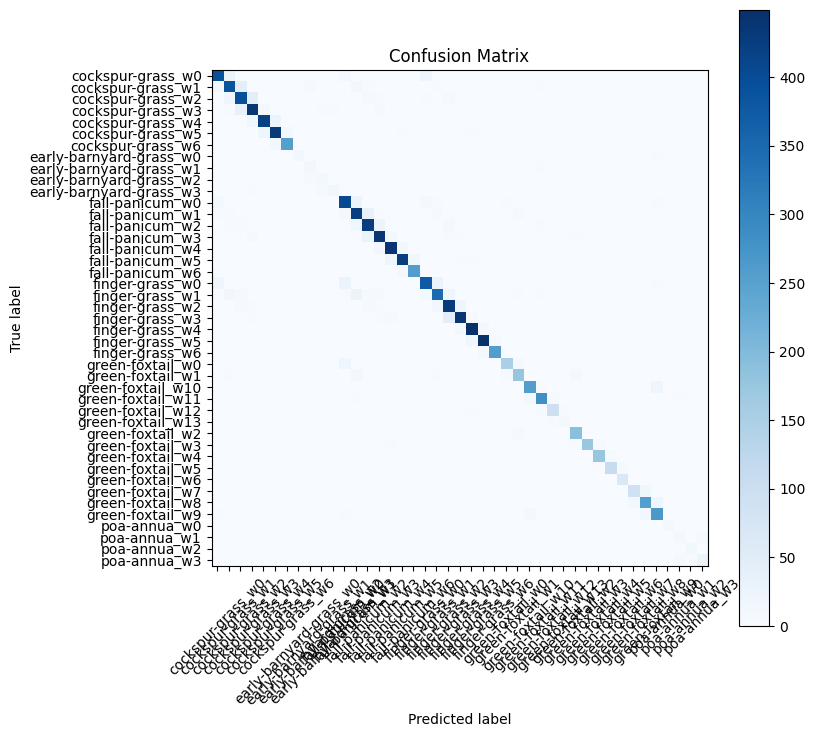

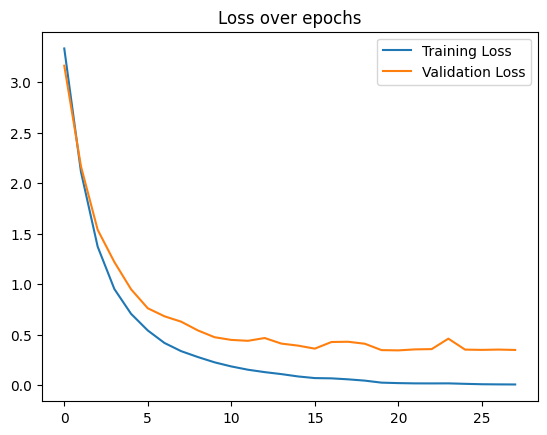

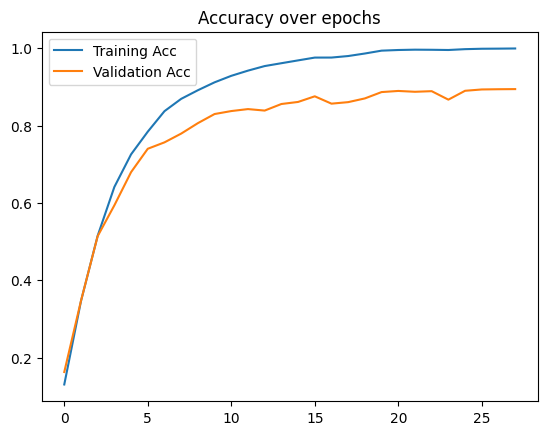

In [7]:
test_flow.reset()
y_true = test_flow.classes
y_pred_probs = model.predict(test_flow)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = list(test_flow.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
test_loss, test_acc = model.evaluate(test_flow, verbose=0)

# Precision, Recall, F1 (macro avg)
precision = report["macro avg"]["precision"]
recall = report["macro avg"]["recall"]
f1 = report["macro avg"]["f1-score"]

# GFLOPS & Params
# flops = get_flops(model, batch_size=1)
num_params = model.count_params()

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# print(f"GFLOPS: {flops/1e9:.4f}")
print(f"Parameters: {num_params}")

# Confusion Matrix 
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Loss/Accuracy Curves 
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(); plt.title("Loss over epochs"); plt.show()
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.legend(); plt.title("Accuracy over epochs"); plt.show()


In [8]:
model.save('ConvNeXtTiny_final_model.keras')
model.save_weights('ConvNeXtTiny_final.weights.h5')

| Model        |   Params |   Test Loss |   Test Acc |   Precision |   Recall |     F1 |
|:-------------|---------:|------------:|-----------:|------------:|---------:|-------:|
| ConvNeXtTiny | 29302155 |      0.3471 |     0.8919 |      0.8558 |   0.8648 | 0.8583 |


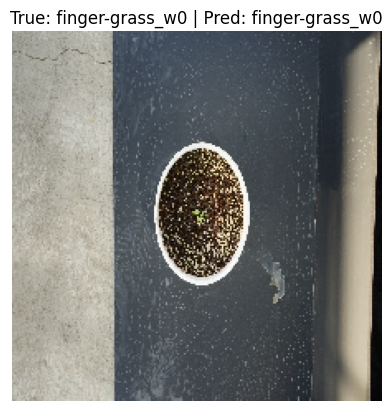

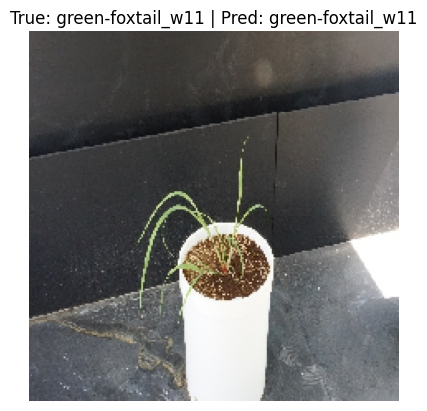

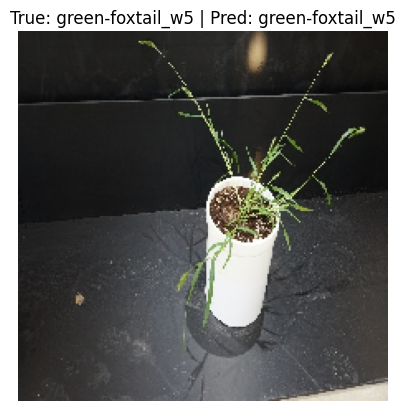

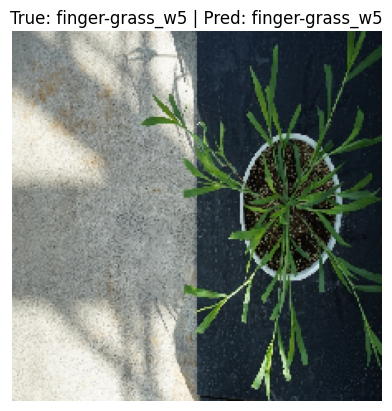

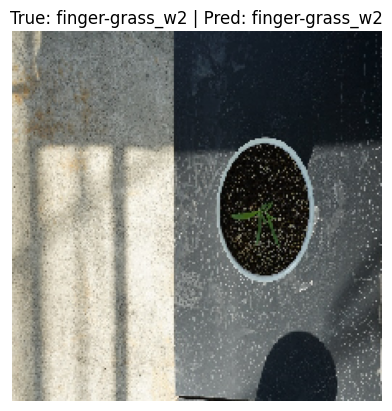

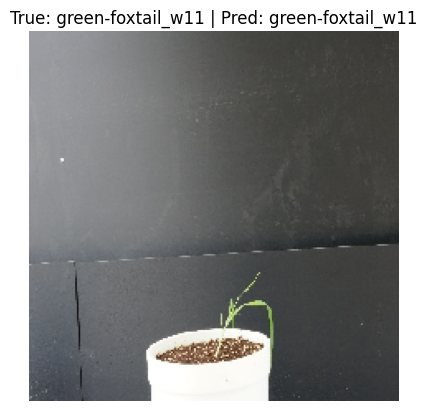

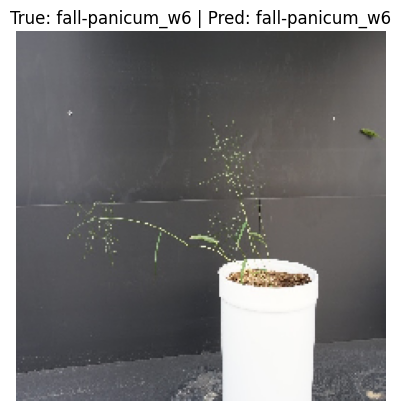

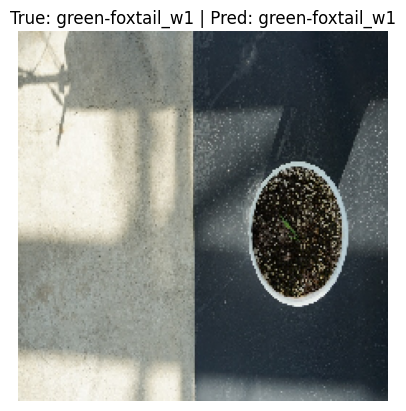

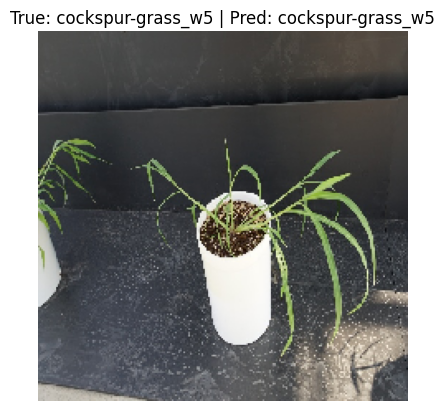

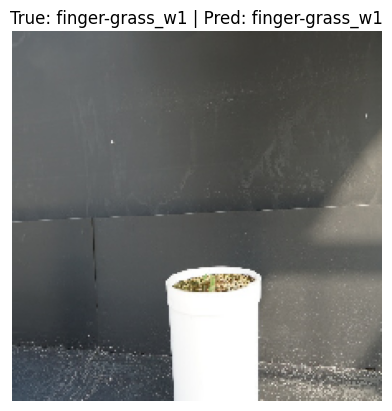

{"id":"f6Z4ie8CmUkr","time":1755971875,"expires":1756015075,"event":"message","topic":"model_complete","message":"Finished"}


In [9]:
import pandas as pd
results = {
    "Model": ["ConvNeXtTiny"],
    "Params": [num_params],
    # "GFLOPS": [f"{flops/1e9:.4f}"],
    "Test Loss": [f"{test_loss:.4f}"],
    "Test Acc": [f"{test_acc:.4f}"],
    "Precision": [f"{precision:.4f}"],
    "Recall": [f"{recall:.4f}"],
    "F1": [f"{f1:.4f}"]
}
df = pd.DataFrame(results)
print(df.to_markdown(index=False))


import random
sample_idx = random.sample(range(test_flow.n), 10)
for idx in sample_idx:
    img_path = test_flow.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    plt.imshow(img)
    true_label = target_names[y_true[idx]]
    pred_label = target_names[y_pred[idx]]
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()

!curl -d "Finished" ntfy.sh/model_complete